In [1]:
!pip install biopandas
!pip install pandas
!pip install numpy
!pip install csv
!pip install pyplot
!pip install mplot3d
!pip install sklearn
!pip install scipy
!pip install seaborn

%matplotlib inline

import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb as PandasPdb
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import sklearn.manifold as manifold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns

In [2]:
df_pdbs = pd.read_csv('pdb_codes.txt', sep=" ", header=None)
df_pdbs = df_pdbs.transpose()
df_pdbs.columns = ['pdb']
collect_dict = {}

In [3]:
key_atoms = ['N1', 'C2', 'O2', 'N3', 'C4', 'O4', 'C4A', 'C4X', 'N5', 'C5A', 'C5X', 'C6', 'C7', 'C7M', 'C8', 'C8M', 'C9', 'C9A', 'N10', 'C10']
key_res = ['FMN', 'FAD']
ambiguous_atom = ['C4A', 'C4X', 'C5A', 'C5X']

In [4]:
#Find index number of N5 to check which of the ambiguous atoms are isoalloxazines
def check_ambiguous_atoms():
    index_N5 = []
    for i in range(len(df_hetatm)): #Use df_hetatm instead of df because distance function reads only separated dataframe
        if df_hetatm.atom_name[i]== 'N5':
            index_N5.append(i)
        else:
            continue
    return(index_N5)

In [5]:
#Find index number of C1 to exclude distant between isoalloxazine and C1 atom
def check_c1_atom():
    index_C1 = []
    for i in range(len(df_hetatm)): #Use df_hetatm instead of df because distance function reads only separated dataframe
        if df_hetatm.atom_name[i] == "C1'":
            index_C1.append(i)
        else:
            continue
    return(index_C1)

In [6]:
'''
Finds the distance between heteroatoms/atoms and isoalloxazine. This function takes in two dictionaries and the 
desired angstrom limit. It uses the Biopandas' distance function to quickly find the distances. This function 
returns two dictionaries containing the distances between isoalloxzine and atoms/heteroatoms.
'''
def find_distance(distance_atom_dict, distance_het_dict, angstrom_limit):    
    i = 0
    for i in range(len(df)):
        if ((df.residue_name[i] in key_res) and (df.atom_name[i] in key_atoms)):
            reference_point = (df.x_coord[i], df.y_coord[i], df.z_coord[i])
            distances_atm = ppdb.distance(xyz=reference_point, records='ATOM')
            distances_het = ppdb.distance(xyz=reference_point, records='HETATM')
            for c1 in check_c1_atom(): #Checking to see if C1 atom is in isoalloxazine
                if (df.residue_number[i] == df_hetatm.residue_number[c1]):
                    distances_het = distances_het.drop(c1)
                else:
                    distances_het = distances_het
            if df.atom_name[i] in ambiguous_atom: #Checking to see which ambiguous atom is correct
                for ind in check_ambiguous_atoms():
                    if distances_het[ind] < 2.0: #If less than 2 Angstroms away, by recommendation of Bruce
                        distance_het_dict[i] = distances_het[distances_het <= angstrom_limit]
                        distance_atom_dict[i] = distances_atm[distances_atm <= angstrom_limit]
                        break
                    else:
                        continue
            else:
                distance_het_dict[i] = distances_het[distances_het <= angstrom_limit]
                distance_atom_dict[i] = distances_atm[distances_atm <= angstrom_limit]
                
    #Remove intra-isoalloxazine distances
    for k,v in distance_het_dict.items():
        for iso in v.index:
            if ((df_hetatm.atom_name[iso] in key_atoms) and (df_hetatm.residue_number[iso] == df.residue_number[k])):
                v = v.drop(iso)
        distance_het_dict[k] = v
        
    #This is to relabel the indices of distance_het_dict from df_hetatm indexes to the combined df indexes
    pairs = {}
    for k,v in distance_het_dict.items():
        lst = []
        if len(v.index) != 0:
            for targ in v.index:
                check_res_numb = df_hetatm.residue_number[targ]
                check_atom_name = df_hetatm.atom_name[targ]
                new_targ = df.index[(df.residue_number == check_res_numb) & (df.atom_name == check_atom_name)]
                lst.append((new_targ.values[0], v[targ]))
            pairs[k] = lst
    
    distance_het_dict = pairs
    
    return (distance_atom_dict, distance_het_dict)

In [7]:
'''
This function creates a dataframe of the distance relationship between each atom in the isoalloxazine and its
surrounding atoms and heteroatoms. It also finds the chemical code associated with the target atom/heteroatom. 
'''
def distance_dataframe(distance_atom_dict, distance_het_dict):
    ref_atom_list = []
    target_atom_list = []
    distance_list = []

    for k,v in distance_atom_dict.items():
        for target, dist in v.iteritems():
            ref_atom_list.append(k)
            target_atom_list.append(target)
            distance_list.append(dist)

    for k,v in distance_het_dict.items():
        for i in v:
            ref_atom_list.append(k)
            target_atom_list.append(i[0])
            distance_list.append(i[1])

    df_dist = pd.DataFrame()
    df_dist['isoalloxazine'] = ref_atom_list
    df_dist['target_atom'] = target_atom_list
    df_dist['distance'] = distance_list
    
    #This is to find the associated chemical code of the target atom/heteroatm
    code_list = []
    for i in df_dist['target_atom']:
        temp = df_codes.index[(df_codes.Residue == df.residue_name[i]) & (df_codes.Atom == df.atom_name[i])]
        if len(temp) != 0:
            code_list.append(df_codes.Code[temp[0]])
        else:
            code_list.append(0) #Every atom is not represented in the code doc Dr. Palfey gave us. 0 for now.

    df_dist['chemical_codes'] = code_list
    
    #This is to find the associated chemical type of the target atom/heteroatm
    chemical_list = []
    for i in df_dist['chemical_codes']:
        temp = df_chemicals.index[df_chemicals.Code == i]
        try:
            chemical_list.append(df_chemicals.Label[temp[0]])
        except:
            chemical_list.append("N/A")
    
    df_dist['chemical_type'] = chemical_list
    
    return(df_dist)

In [8]:
#Use kmeans clustering to cluster flavoproteins together based on count of atom chemical tpyes
def kmeans_cluster(df):
    number_of_cluster = np.round(np.sqrt(len(df)/2))
    
    kmeans_model = skc.KMeans(n_clusters=int(number_of_cluster))
    kmeans_model.fit(df)
    
    centroids = kmeans_model.cluster_centers_
    df['cluster_labels_kmeans'] = kmeans_model.labels_
    
    return(df)

In [9]:
#Create a dendrogram using heirarchical clustering
def create_dendrogram(df_value):
    dist_value = spd.squareform(spd.pdist(df_value,metric='euclidean'))
    dist_value.shape
    Z_lang = sph.linkage(dist_value,method='ward') #Choose between single, complete, ward for method
    _ = sph.dendrogram(Z_lang, labels=df_value.index, orientation='left')
    plt.xlabel('Data Points')
    plt.ylabel('Flavoproteins')
    plt.suptitle('Dendrogram: Chemical-type count at ' + str(angstrom_limit) + ' limit', 
                 fontweight='bold', fontsize=14);

### "Main" Function ###
This code doesn't have a main(). This is because the code is looping through all the available pdb files. Dataframes and key variables have to constantly be updated for the next pdb file.

In [ ]:
angstrom_limit = float(input("Please enter desired angstrom limit: "))
bioassembly = input("Please enter bioassembly number. Enter 0 if not needed: ")
flavoprotein = df_pdbs['pdb']

for pdb in flavoprotein:
    #Checks to see if pdb file is downloaded
    try:
        #Checks to see if user wants to load biological assemblies or not
        if bioassembly == '0':
            ppdb = PandasPdb().read_pdb("/Volumes/USB20FD/FlavinTest/%s.pdb" % pdb)
        else:
            ppdb = PandasPdb().read_pdb("/Volumes/USB20FD/FlavinTest/%s.pdb" % pdb + bioassembly)
        
        #Create dataframe of flavoprotein from pdb file
        df_atom = ppdb.df['ATOM']
        df_hetatm = ppdb.df['HETATM']
        df = pd.concat([df_atom, df_hetatm])
        df = df.reset_index(drop=True)

        #Dataframe of the codes for atom types
        df_codes = pd.read_csv("code.csv")

        #Dataframe of the chemical names of the codes
        df_chemicals = pd.read_csv("code_labels.csv")
        
        #Create dictionaries to hold distances
        distance_atom_dict = {}
        distance_het_dict = {}
        
        #Fill dictionaries with distances from 'distance' function
        distances = find_distance(distance_atom_dict, distance_het_dict, angstrom_limit)
        distance_atom_dict = distances[0]
        distance_het_dict = distances[1]
        
        #Create dataframe of distances
        df_distance = distance_dataframe(distance_atom_dict, distance_het_dict)
        
        #Dictionary the holds informaion on count of chemical types for each flavoprotein
        collect_dict[pdb] = df_distance.chemical_type.value_counts()
        
        #Fill dataframe with 'collect_dict' information
        df_value = pd.DataFrame(collect_dict)
        df_value = df_value.transpose()
        df_value = df_value.fillna(0)
        df_value = df_value.astype(int)
        
        print(pdb, end='')
    except:
        continue
        
df_value = kmeans_cluster(df_value)

Please enter desired angstrom limit: 3.5
Please enter bioassembly number. Enter 0 if not needed: 1
1ahv1ahz1amo1an91aog1b2r1b371b4v1b5q1b5t1b8s1bf31bgj1bgn1bhy1bjk1bkw1bqe1buc1bwc1bx01bx11bzl1c0i1c0k1c0l1c0p1cbo1cc21cc41cc61cf31cj21cj31cj41cjc1cl01cne1cnf1coy1cqx1d4a1d4c1d4d1d4e1d7y1ddg1ddi1ddo1dii1diq1dnc1dnp1dob1doc1dod1doe1dxl1dxo1dxq1dzn1e0y1e1k1e1l1e1m1e1n1e6e1e7p1e8g1ebd1efp1efv1egc1egd1ege1el51el71el81el91eli1ep11ep21ep31evi1ewy1f0x1f201f3p1f6m

In [ ]:
df_value.head()

/Users/davidkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


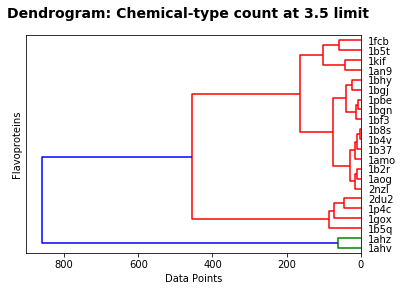

In [267]:
create_dendrogram(df_value)